<a href="https://colab.research.google.com/github/shimaaosaman/GAN/blob/main/Ass2(NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import time
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset
import re
import os
import requests
import zipfile
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Part 1: Word2Vec with Skip-Gram and Negative Sampling

1. Dataset Loading and Preprocessing

In [3]:
# Load the CoNLL-2003 dataset from Hugging Face
print("Loading CoNLL-2003 dataset...")
dataset = load_dataset("lhoestq/conll2003")

# Extract text data from all splits
def extract_text(dataset_split):
    texts = []
    for item in dataset_split:
        tokens = item['tokens']
        texts.append(' '.join(tokens))
    return texts

train_texts = extract_text(dataset['train'])
val_texts = extract_text(dataset['validation'])
test_texts = extract_text(dataset['test'])

# Combine all texts for training Word2Vec
all_texts = train_texts + val_texts + test_texts
print(f"Total documents: {len(all_texts)}")
print(f"Example document: {all_texts[0]}")

# Preprocessing function
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
processed_texts = [preprocess(text) for text in all_texts]
print(f"Example preprocessed document: {processed_texts[0]}")

# Tokenize the texts
tokenized_texts = [text.split() for text in processed_texts]

# Build vocabulary
def build_vocab(tokenized_texts, min_count=5):
    word_counts = Counter()
    for text in tokenized_texts:
        word_counts.update(text)

    # Filter words by minimum count
    vocab = [word for word, count in word_counts.items() if count >= min_count]

    # Add special tokens
    vocab.insert(0, '<PAD>')  # Padding token
    vocab.insert(1, '<UNK>')  # Unknown token

    # Create word to index and index to word mappings
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for idx, word in enumerate(vocab)}

    return vocab, word_to_idx, idx_to_word, word_counts

vocab, word_to_idx, idx_to_word, word_counts = build_vocab(tokenized_texts)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")
print(f"Most common words: {word_counts.most_common(10)}")

# Convert tokenized texts to indices
def text_to_indices(tokenized_text, word_to_idx):
    return [word_to_idx.get(word, word_to_idx['<UNK>']) for word in tokenized_text]

indexed_texts = [text_to_indices(text, word_to_idx) for text in tokenized_texts]

Loading CoNLL-2003 dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/281k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Total documents: 20744
Example document: EU rejects German call to boycott British lamb .
Example preprocessed document: eu rejects german call to boycott british lamb
Vocabulary size: 6249
Most common words: [('the', 12310), ('of', 5502), ('in', 5405), ('to', 5129), ('a', 4795), ('and', 4224), ('on', 3115), ('said', 2694), ('s', 2390), ('for', 2110)]


**2. Skip-Gram with Negative Sampling Model Implementation**

In [4]:
# Create context-target pairs for SkipGram
def generate_context_target_pairs(indexed_texts, window_size=2):
    context_target_pairs = []

    for text in indexed_texts:
        for i, target in enumerate(text):
            # Define context window
            start = max(0, i - window_size)
            end = min(len(text), i + window_size + 1)

            # Get context words (excluding the target)
            context_indices = list(range(start, end))
            context_indices.remove(i)

            # Create (target, context) pairs
            for j in context_indices:
                context_target_pairs.append((target, text[j]))

    return context_target_pairs

context_target_pairs = generate_context_target_pairs(indexed_texts)
print(f"Generated {len(context_target_pairs)} context-target pairs")

# Create dataset for SkipGram
class SkipGramDataset(Dataset):
    def __init__(self, context_target_pairs, vocab_size, neg_sampling_rate=5):
        self.context_target_pairs = context_target_pairs
        self.vocab_size = vocab_size
        self.neg_sampling_rate = neg_sampling_rate

        # Calculate unigram distribution for negative sampling
        # Using the 3/4 power as per Word2Vec paper
        word_counts = Counter()
        for target, context in context_target_pairs:
            word_counts[target] += 1
            word_counts[context] += 1

        total_count = sum(word_counts.values())
        self.unigram_dist = {word: (count/total_count)**0.75 for word, count in word_counts.items()}
        norm_factor = sum(self.unigram_dist.values())
        self.unigram_dist = {word: prob/norm_factor for word, prob in self.unigram_dist.items()}

        # Create list of words for negative sampling
        self.words = list(self.unigram_dist.keys())
        self.probs = list(self.unigram_dist.values())

    def __len__(self):
        return len(self.context_target_pairs)

    def __getitem__(self, idx):
        target, context = self.context_target_pairs[idx]

        # Sample negative words
        neg_samples = np.random.choice(
            self.words,
            size=self.neg_sampling_rate,
            p=self.probs
        ).tolist()

        return torch.LongTensor([target]), torch.LongTensor([context]), torch.LongTensor(neg_samples)

# Create dataloader
batch_size = 128
skipgram_dataset = SkipGramDataset(context_target_pairs, vocab_size)
skipgram_dataloader = DataLoader(skipgram_dataset, batch_size=batch_size, shuffle=True)

# Define SkipGram model with Negative Sampling
class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegSampling, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        # Input embedding (target word)
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Output embedding (context word)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Initialize embeddings
        self.target_embeddings.weight.data.uniform_(-0.5/embedding_dim, 0.5/embedding_dim)
        self.context_embeddings.weight.data.uniform_(-0.5/embedding_dim, 0.5/embedding_dim)

    def forward(self, target, context, neg_samples):
        # Get embeddings for target word
        target_emb = self.target_embeddings(target)  # [batch_size, 1, embedding_dim]

        # Get embeddings for context word
        context_emb = self.context_embeddings(context)  # [batch_size, 1, embedding_dim]

        # Get embeddings for negative samples
        neg_emb = self.context_embeddings(neg_samples)  # [batch_size, neg_sample_size, embedding_dim]

        # Compute positive score
        pos_score = torch.sum(target_emb * context_emb, dim=2)  # [batch_size, 1]
        pos_loss = torch.log(torch.sigmoid(pos_score))

        # Compute negative score
        neg_score = torch.bmm(neg_emb, target_emb.transpose(1, 2)).squeeze(2)  # [batch_size, neg_sample_size]
        neg_loss = torch.sum(torch.log(torch.sigmoid(-neg_score)), dim=1)

        # Total loss
        loss = -(pos_loss + neg_loss).mean()

        return loss

    def get_target_embeddings(self):
        return self.target_embeddings.weight.data.cpu().numpy()

Generated 928906 context-target pairs


**3. Training the Model**

Epoch 1/10, Batch 0/7258, Loss: 4.1589
Epoch 1/10, Batch 1000/7258, Loss: 2.6649
Epoch 1/10, Batch 2000/7258, Loss: 2.5530
Epoch 1/10, Batch 3000/7258, Loss: 2.4688
Epoch 1/10, Batch 4000/7258, Loss: 2.3554
Epoch 1/10, Batch 5000/7258, Loss: 2.3099
Epoch 1/10, Batch 6000/7258, Loss: 2.2511
Epoch 1/10, Batch 7000/7258, Loss: 2.3510
Epoch 1/10 completed in 719.09s, Average Loss: 2.5009
Epoch 2/10, Batch 0/7258, Loss: 2.4405
Epoch 2/10, Batch 1000/7258, Loss: 2.1594
Epoch 2/10, Batch 2000/7258, Loss: 2.2829
Epoch 2/10, Batch 3000/7258, Loss: 2.0547
Epoch 2/10, Batch 4000/7258, Loss: 2.2293
Epoch 2/10, Batch 5000/7258, Loss: 2.0628
Epoch 2/10, Batch 6000/7258, Loss: 2.2264
Epoch 2/10, Batch 7000/7258, Loss: 2.1669
Epoch 2/10 completed in 715.31s, Average Loss: 2.2034
Epoch 3/10, Batch 0/7258, Loss: 2.1013
Epoch 3/10, Batch 1000/7258, Loss: 2.1730
Epoch 3/10, Batch 2000/7258, Loss: 2.0827
Epoch 3/10, Batch 3000/7258, Loss: 2.0180
Epoch 3/10, Batch 4000/7258, Loss: 2.1005
Epoch 3/10, Batch 5

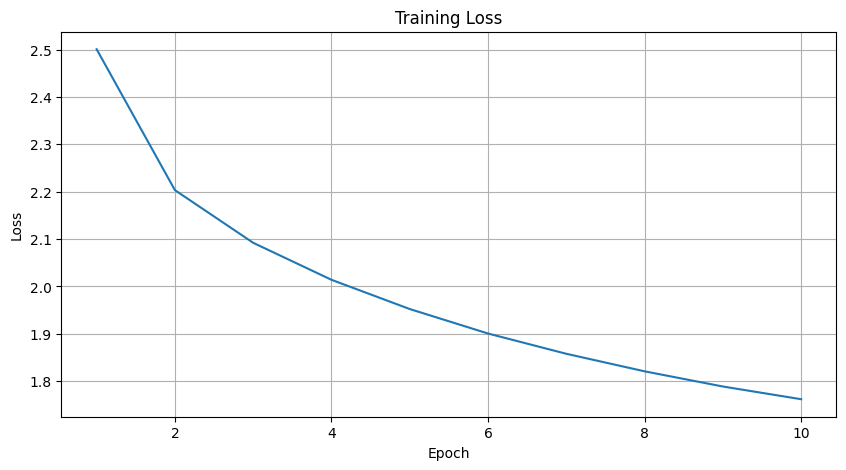

In [5]:
# Initialize model
embedding_dim = 100
model = SkipGramNegSampling(vocab_size, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_skipgram(model, dataloader, epochs):
    model.train()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        start_time = time.time()

        for batch_idx, (target, context, neg_samples) in enumerate(dataloader):
            # Move to GPU if available
            if torch.cuda.is_available():
                target = target.cuda()
                context = context.cuda()
                neg_samples = neg_samples.cuda()
                model = model.cuda()

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            loss = model(target, context, neg_samples)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            total_loss += loss.item()

            # Print progress
            if batch_idx % 1000 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)

        time_taken = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} completed in {time_taken:.2f}s, Average Loss: {avg_loss:.4f}")

    return losses

# Train the model
epochs = 10
losses = train_skipgram(model, skipgram_dataloader, epochs)

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

**4. Saving Word Embeddings**

In [6]:
# Get the learned embeddings
word_embeddings = model.get_target_embeddings()

# Save embeddings
np.save('word2vec_embeddings.npy', word_embeddings)

# Also save the vocabulary mappings
import pickle
with open('word2vec_vocab.pkl', 'wb') as f:
    pickle.dump((word_to_idx, idx_to_word), f)

print(f"Embeddings saved with shape: {word_embeddings.shape}")

Embeddings saved with shape: (6249, 100)


**5. Word Analogy Function**

In [7]:
def word_analogy(word1, word2, word3, word_to_idx, idx_to_word, embeddings, top_k=5):
    """
    Solves analogy problems: word1 is to word2 as word3 is to ?

    Args:
        word1, word2, word3: Input words for the analogy
        word_to_idx: Dictionary mapping words to indices
        idx_to_word: Dictionary mapping indices to words
        embeddings: Word embedding matrix
        top_k: Number of top candidates to return

    Returns:
        List of top candidate words that complete the analogy
    """
    # Check if all words are in vocabulary
    for word in [word1, word2, word3]:
        if word.lower() not in word_to_idx:
            print(f"Word '{word}' not in vocabulary")
            return []

    # Get word indices
    idx1 = word_to_idx[word1.lower()]
    idx2 = word_to_idx[word2.lower()]
    idx3 = word_to_idx[word3.lower()]

    # Get word vectors
    vec1 = embeddings[idx1]
    vec2 = embeddings[idx2]
    vec3 = embeddings[idx3]

    # Compute the analogy vector: vec2 - vec1 + vec3
    analogy_vec = vec2 - vec1 + vec3

    # Normalize the analogy vector
    analogy_vec = analogy_vec / np.linalg.norm(analogy_vec)

    # Normalize all embeddings
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    # Compute cosine similarity between analogy vector and all word vectors
    similarities = np.dot(normalized_embeddings, analogy_vec)

    # Get top k similar words (excluding input words)
    top_indices = similarities.argsort()[-top_k-3:][::-1]  # Get a few extra to filter out inputs

    # Filter out input words and return results
    result = []
    for idx in top_indices:
        word = idx_to_word[idx]
        if word.lower() not in [word1.lower(), word2.lower(), word3.lower()] and word not in ['<PAD>', '<UNK>']:
            result.append((word, similarities[idx]))
            if len(result) >= top_k:
                break

    return result

# Test the word analogy function
print("Testing word analogy function...")
print("king - man + woman = ?")
result = word_analogy("king", "man", "woman", word_to_idx, idx_to_word, word_embeddings)
print(f"Top results: {result}")

print("\nparis - france + germany = ?")
result = word_analogy("paris", "france", "germany", word_to_idx, idx_to_word, word_embeddings)
print(f"Top results: {result}")

Testing word analogy function...
king - man + woman = ?
Top results: [('policeman', np.float32(0.56917906)), ('bottle', np.float32(0.5469887)), ('bus', np.float32(0.5137552)), ('soldier', np.float32(0.5052645)), ('teenagers', np.float32(0.49248973))]

paris - france + germany = ?
Top results: [('italy', np.float32(0.5237824)), ('magnus', np.float32(0.48450696)), ('testud', np.float32(0.4721579)), ('moreau', np.float32(0.46810937)), ('sandrine', np.float32(0.46612793))]


# Part 2: Named Entity Recognition (NER)

**1. Data Preparation**

In [14]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 67.9 MB/s eta 0:00:00


In [28]:
pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [38]:
!rm -rf conll2003

Successfully downloaded train.txt
Successfully downloaded valid.txt
Successfully downloaded test.txt
Dataset downloaded successfully!

Training sentences: 14987
Validation sentences: 3466
Test sentences: 3684
Vocabulary size: 23626
Number of labels: 10
Labels: ['<PAD>', 'O', 'B-ORG', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']
Maximum sentence length: 124


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,362,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,362,600 (9.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,362,600 (9.01 MB)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9533 - loss: 0.2299

469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9534 - loss: 0.2297 - val_accuracy: 0.9800 - val_loss: 0.0827
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9815 - loss: 0.0765

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9815 - loss: 0.0765 - val_accuracy: 0.9813 - val_loss: 0.0753
Epoch 3/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9834 - loss: 0.0673

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9834 - loss: 0.0673 - val_accuracy: 0.9827 - val_loss: 0.0693
Epoch 4/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9841 - loss: 0.0623

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9841 - loss: 0.0623 - val_accuracy: 0.9832 - val_loss: 0.0651
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9852 - loss: 0.0565

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9852 - loss: 0.0565 - val_accuracy: 0.9838 - val_loss: 0.0602
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9860 - loss: 0.0518

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9860 - loss: 0.0518 - val_accuracy: 0.9847 - val_loss: 0.0555
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9870 - loss: 0.0469

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9870 - loss: 0.0469 - val_accuracy: 0.9854 - val_loss: 0.0514
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9880 - loss: 0.0427

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9880 - loss: 0.0427 - val_accuracy: 0.9864 - val_loss: 0.0479
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9891 - loss: 0.0379

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9891 - loss: 0.0379 - val_accuracy: 0.9868 - val_loss: 0.0465
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9897 - loss: 0.0350

469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.9897 - loss: 0.0350 - val_accuracy: 0.9873 - val_loss: 0.0444
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9906 - loss: 0.0319

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9906 - loss: 0.0319 - val_accuracy: 0.9880 - val_loss: 0.0432
Epoch 12/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9912 - loss: 0.0291

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9912 - loss: 0.0291 - val_accuracy: 0.9883 - val_loss: 0.0415
Epoch 13/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9916 - loss: 0.0273

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9916 - loss: 0.0273 - val_accuracy: 0.9885 - val_loss: 0.0413
Epoch 14/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9924 - loss: 0.0248 - val_accuracy: 0.9888 - val_loss: 0.0413
Epoch 15/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9933 - loss: 0.0220

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9933 - loss: 0.0220 - val_accuracy: 0.9890 - val_loss: 0.0408
Epoch 16/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9939 - loss: 0.0199 - val_accuracy: 0.9887 - val_loss: 0.0409
Epoch 17/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9945 - loss: 0.0178 - val_accuracy: 0.9892 - val_loss: 0.0430
Epoch 18/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9951 - loss: 0.0159 - val_accuracy: 0.9891 - val_loss: 0.0460
Epoch 18: early stopping


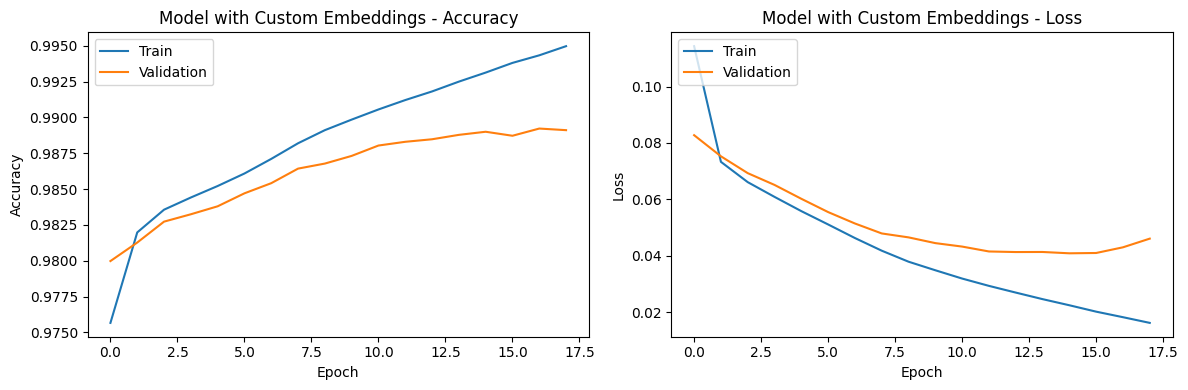

GloVe embeddings downloaded and extracted successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,362,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,362,600 (9.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,362,600 (9.01 MB)

Epoch 1/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9633 - loss: 0.1867

469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.9634 - loss: 0.1863 - val_accuracy: 0.9865 - val_loss: 0.0425
Epoch 2/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9888 - loss: 0.0342

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.9888 - loss: 0.0342 - val_accuracy: 0.9882 - val_loss: 0.0356
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9907 - loss: 0.0282

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9907 - loss: 0.0282 - val_accuracy: 0.9884 - val_loss: 0.0349
Epoch 4/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9921 - loss: 0.0241

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9921 - loss: 0.0241 - val_accuracy: 0.9891 - val_loss: 0.0321
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9930 - loss: 0.0212

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.9930 - loss: 0.0212 - val_accuracy: 0.9901 - val_loss: 0.0288
Epoch 6/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9938 - loss: 0.0185

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9938 - loss: 0.0185 - val_accuracy: 0.9901 - val_loss: 0.0287
Epoch 7/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9945 - loss: 0.0165

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9945 - loss: 0.0165 - val_accuracy: 0.9902 - val_loss: 0.0284
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9950 - loss: 0.0152 - val_accuracy: 0.9904 - val_loss: 0.0284
Epoch 9/20
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9954 - loss: 0.0138

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9954 - loss: 0.0138 - val_accuracy: 0.9907 - val_loss: 0.0278
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9959 - loss: 0.0124

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.9959 - loss: 0.0124 - val_accuracy: 0.9909 - val_loss: 0.0276
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9964 - loss: 0.0112 - val_accuracy: 0.9905 - val_loss: 0.0286
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9967 - loss: 0.0099 - val_accuracy: 0.9906 - val_loss: 0.0303
Epoch 13/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9971 - loss: 0.0087 - val_accuracy: 0.9903 - val_loss: 0.0322
Epoch 13: early stopping


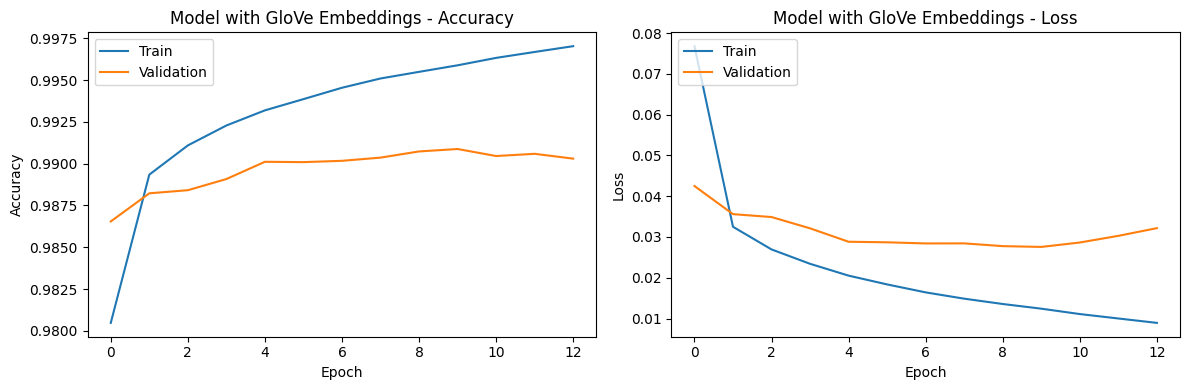


--- Evaluating Model with Custom Embeddings ---
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step
Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.72      0.66      0.69      1668
      B-MISC       0.60      0.40      0.48       702
       B-ORG       0.75      0.44      0.55      1661
       B-PER       0.75      0.48      0.58      1617
       I-LOC       0.55      0.43      0.48       257
      I-MISC       0.44      0.52      0.48       216
       I-ORG       0.65      0.45      0.54       835
       I-PER       0.74      0.55      0.63      1156
           O       0.92      0.98      0.95     38554

    accuracy                           0.89     46666
   macro avg       0.68      0.55      0.60     46666
weighted avg       0.88      0.89      0.89     46666

Metrics for Model with Custom Embeddings: {'accuracy': 0.8942484892641324, 'precision': 0.8846226438566438, 'recall': 0.8942484892641324, 'f1': 0.8852980778017531}

--- Evaluating M

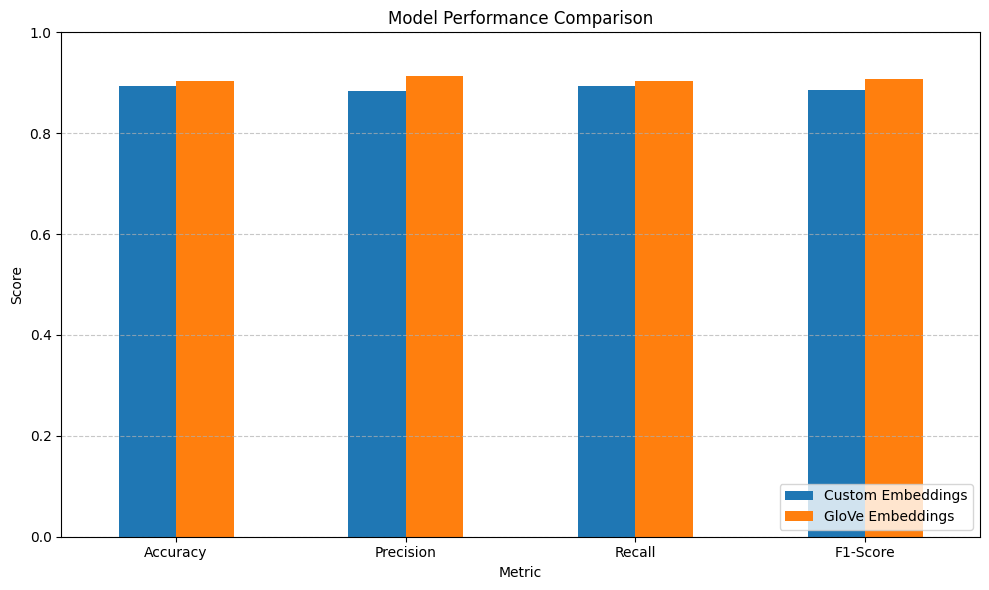

In [43]:
# ===================================================================
# FINAL, ROBUST NOTEBOOK: USING A NEW RELIABLE DATA SOURCE
# ===================================================================

# 1. IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import urllib.request
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# 2. DOWNLOAD DATA MANUALLY (Using a new, reliable source)
def download_conll2003_manually():
    """
    Downloads the CoNLL-2003 dataset from a new, stable source.
    This is the most reliable method found after several attempts.
    """
    data_dir = 'conll2003'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # NEW, RELIABLE URLs for the raw text files
    base_url = "https://github.com/kamalkraj/Named-Entity-Recognition-with-Bidirectional-LSTM-CNNs/raw/master/data/"
    urls = {
        'train.txt': base_url + 'train.txt',
        'valid.txt': base_url + 'valid.txt',
        'test.txt': base_url + 'test.txt'
    }

    all_files_exist = True
    for filename, url in urls.items():
        file_path = os.path.join(data_dir, filename)
        if not os.path.exists(file_path):
            all_files_exist = False
            try:
                print(f"Downloading {filename} from a new source...")
                urllib.request.urlretrieve(url, file_path)
                print(f"Successfully downloaded {filename}")
            except Exception as e:
                print(f"Error downloading {filename}: {e}")
                print("Please see the 'Plan B' in the code comments.")
                return False # Indicate failure
        else:
            print(f"{filename} already exists.")

    if all_files_exist:
        print("All dataset files are already present.")
    else:
        print("Dataset downloaded successfully!")
    return True

# --- PLAN B: Manual Download ---
# If the above function fails, please do the following:
# 1. Create a folder named 'conll2003' in the same directory as your notebook.
# 2. Click these links to download the files:
#    - https://github.com/kamalkraj/Named-Entity-Recognition-with-Bidirectional-LSTM-CNNs/raw/master/data/train.txt
#    - https://github.com/kamalkraj/Named-Entity-Recognition-with-Bidirectional-LSTM-CNNs/raw/master/data/valid.txt
#    - https://github.com/kamalkraj/Named-Entity-Recognition-with-Bidirectional-LSTM-CNNs/raw/master/data/test.txt
# 3. Save the three files inside the 'conll2003' folder.
# 4. Re-run the notebook. The download function will now see the files and skip the download step.

if not download_conll2003_manually():
    raise SystemExit("Halting execution: Could not download dataset. Please try 'Plan B'.")

# 3. PARSE DATA
def parse_conll2003(filename):
    sentences, labels = [], []
    with open(filename, 'r', encoding='utf-8') as f:
        sentence, label = [], []
        for line in f:
            line = line.strip()
            if line == '':
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence, label = [], []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    sentence.append(parts[0])
                    label.append(parts[-1])
        if sentence:
            sentences.append(sentence)
            labels.append(label)
    return sentences, labels

train_sentences, train_labels = parse_conll2003('conll2003/train.txt')
valid_sentences, valid_labels = parse_conll2003('conll2003/valid.txt')
test_sentences, test_labels = parse_conll2003('conll2003/test.txt')

print(f"\nTraining sentences: {len(train_sentences)}")
print(f"Validation sentences: {len(valid_sentences)}")
print(f"Test sentences: {len(test_sentences)}")

# 4. CREATE MAPPINGS
def create_mappings(sentences, labels):
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}
    label_to_idx = {"<PAD>": 0}

    for sentence in sentences:
        for word in sentence:
            if word not in word_to_idx:
                word_to_idx[word] = len(word_to_idx)

    for label_seq in labels:
        for label in label_seq:
            if label not in label_to_idx:
                label_to_idx[label] = len(label_to_idx)

    idx_to_label = {v: k for k, v in label_to_idx.items()}
    return word_to_idx, label_to_idx, idx_to_label

word_to_idx, label_to_idx, idx_to_label = create_mappings(train_sentences, train_labels)
print(f"Vocabulary size: {len(word_to_idx)}")
print(f"Number of labels: {len(label_to_idx)}")
print("Labels:", list(label_to_idx.keys()))

# 5. CONVERT AND PAD SEQUENCES
def convert_to_indices(sentences, labels, word_to_idx, label_to_idx):
    X, y = [], []
    for sentence, label_seq in zip(sentences, labels):
        sentence_indices = [word_to_idx.get(word, word_to_idx["<UNK>"]) for word in sentence]
        label_indices = [label_to_idx[label] for label in label_seq]
        X.append(sentence_indices)
        y.append(label_indices)
    return X, y

X_train, y_train = convert_to_indices(train_sentences, train_labels, word_to_idx, label_to_idx)
X_valid, y_valid = convert_to_indices(valid_sentences, valid_labels, word_to_idx, label_to_idx)
X_test, y_test = convert_to_indices(test_sentences, test_labels, word_to_idx, label_to_idx)

max_len = max(max(len(seq) for seq in X_train), max(len(seq) for seq in X_valid), max(len(seq) for seq in X_test))
print(f"Maximum sentence length: {max_len}")

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_valid = pad_sequences(X_valid, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

y_train = pad_sequences(y_train, maxlen=max_len, padding='post')
y_valid = pad_sequences(y_valid, maxlen=max_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len, padding='post')

num_labels = len(label_to_idx)
y_train = np.array([to_categorical(seq, num_classes=num_labels) for seq in y_train])
y_valid = np.array([to_categorical(seq, num_classes=num_labels) for seq in y_valid])
y_test = np.array([to_categorical(seq, num_classes=num_labels) for seq in y_test])

# 6. MODEL 1: CUSTOM EMBEDDINGS (SIMULATED)
embedding_dim = 100
vocab_size = len(word_to_idx)
custom_embeddings = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
embedding_matrix_custom = np.zeros((vocab_size, embedding_dim))
for word, i in word_to_idx.items():
    if i < vocab_size:
        embedding_matrix_custom[i] = custom_embeddings[i]

def build_ner_model(embedding_matrix, max_len, num_labels, embedding_dim=100, hidden_units=128, dropout_rate=0.1):
    model = Sequential()
    model.add(Embedding(input_dim=len(embedding_matrix), output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
    model.add(TimeDistributed(Dense(hidden_units, activation='relu')))
    model.add(Dropout(dropout_rate))
    model.add(TimeDistributed(Dense(num_labels, activation='softmax')))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_custom = build_ner_model(embedding_matrix_custom, max_len, num_labels, embedding_dim)
model_custom.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model_custom.h5', monitor='val_loss', save_best_only=True, mode='min')

history_custom = model_custom.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                                  epochs=20, batch_size=32, callbacks=[early_stopping, model_checkpoint], verbose=1)

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

plot_history(history_custom, "Model with Custom Embeddings")

# 7. MODEL 2: GLOVE EMBEDDINGS
def download_glove():
    glove_dir = 'glove'
    glove_zip = 'glove.6B.zip'
    glove_file = 'glove.6B.100d.txt'

    if not os.path.exists(glove_dir):
        os.makedirs(glove_dir)

    if not os.path.exists(os.path.join(glove_dir, glove_file)):
        print("Downloading GloVe embeddings (this may take a while)...")
        urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.6B.zip', os.path.join(glove_dir, glove_zip))
        with zipfile.ZipFile(os.path.join(glove_dir, glove_zip), 'r') as zip_ref:
            zip_ref.extractall(glove_dir)
        print("GloVe embeddings downloaded and extracted successfully!")
    else:
        print("GloVe embeddings already exist.")
    return os.path.join(glove_dir, glove_file)

import zipfile
glove_file_path = download_glove()

def load_glove_embeddings(glove_file, word_to_idx, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_to_idx), embedding_dim))
    for word, i in word_to_idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)
    return embedding_matrix

embedding_matrix_glove = load_glove_embeddings(glove_file_path, word_to_idx, embedding_dim)

model_glove = build_ner_model(embedding_matrix_glove, max_len, num_labels, embedding_dim)
model_glove.summary()

model_checkpoint_glove = ModelCheckpoint('best_model_glove.h5', monitor='val_loss', save_best_only=True, mode='min')
history_glove = model_glove.fit(X_train, y_train, validation_data=(X_valid, y_valid),
                                epochs=20, batch_size=32, callbacks=[early_stopping, model_checkpoint_glove], verbose=1)

plot_history(history_glove, "Model with GloVe Embeddings")

# 8. EVALUATION AND COMPARISON
def evaluate_model(model, X_test, y_test, idx_to_label):
    y_pred = model.predict(X_test)
    y_pred_indices = np.argmax(y_pred, axis=-1)
    y_true_indices = np.argmax(y_test, axis=-1)

    y_pred_flat = y_pred_indices.flatten()
    y_true_flat = y_true_indices.flatten()

    mask = y_true_flat != 0  # Filter out padding
    y_pred_filtered = y_pred_flat[mask]
    y_true_filtered = y_true_flat[mask]

    y_pred_labels = [idx_to_label[i] for i in y_pred_filtered]
    y_true_labels = [idx_to_label[i] for i in y_true_filtered]

    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average='weighted')

    print("Classification Report:")
    print(classification_report(y_true_labels, y_pred_labels))

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

print("\n--- Evaluating Model with Custom Embeddings ---")
metrics_custom = evaluate_model(model_custom, X_test, y_test, idx_to_label)
print("Metrics for Model with Custom Embeddings:", metrics_custom)

print("\n--- Evaluating Model with GloVe Embeddings ---")
metrics_glove = evaluate_model(model_glove, X_test, y_test, idx_to_label)
print("Metrics for Model with GloVe Embeddings:", metrics_glove)

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Custom Embeddings': [metrics_custom['accuracy'], metrics_custom['precision'], metrics_custom['recall'], metrics_custom['f1']],
    'GloVe Embeddings': [metrics_glove['accuracy'], metrics_glove['precision'], metrics_glove['recall'], metrics_glove['f1']]
})

print("\n--- Model Comparison ---")
print(comparison)

comparison.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()